In [1]:
%matplotlib inline

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import vaex
import pandas as pd
import dask
import dask.dataframe as dd
import numpy as np
import multiprocessing
from tqdm import tqdm
import time

In [3]:
n = 10**7
s = np.arange(n).astype(str)
vx_df = vaex.from_arrays(s=s)

In [4]:
file = './data/test.hdf5'
vx_df.export(file, progress=True, shuffle=True)

[####################################----]:  90.00% estimated time:        0s =  0.0m =  0.0h 

In [5]:
vx_df = vaex.open(file)
vx_df.executor.buffer_size = len(vx_df) // (multiprocessing.cpu_count() * 2)
pd_df = vx_df.to_pandas_df()
dd_df = dd.from_pandas(pd_df, npartitions=4)

In [6]:
def timeit(expr, n, scope):
    times = []
    for i in range(n):
        s = time.time()
        eval(expr, scope)
        e = time.time()
        times.append(e - s)

    return times

In [7]:
methods = {
	'capitalize': 'df.s.str.capitalize()',
	'cat': 'df.s.str.cat(df.s)',
	'contains': 'df.s.str.contains("9", regex=False)',
	'contains(regex)': 'df.s.str.contains("9", regex=True)',
	'count': 'df.s.str.count("9")',
	'endswith': 'df.s.str.endswith("9")',
	'find': 'df.s.str.find("4")',
	'get': 'df.s.str.get(1)',
	'split+join': 'df.s.str.split(".").str.join("-")',
	'len': 'df.s.str.len()',
	'ljust': 'df.s.str.ljust(10)',
	'lower': 'df.s.str.lower()',
	'lstrip': 'df.s.str.lstrip("9")',
	'match': 'df.s.str.match("1.*")',
	'pad': 'df.s.str.pad(10)',
	'repeat': 'df.s.str.repeat(2)',
	'replace(:default)': 'df.s.str.replace("123", "321")',
	'replace(:no regex)': 'df.s.str.replace("123", "321", regex=False)',
	'replace(:regex)': 'df.s.str.replace("1?[45]4", "1004", regex=True)',
	'rfind': 'df.s.str.rfind("4")',
	'rjust': 'df.s.str.rjust(10)',
	'rstrip': 'df.s.str.rstrip("9")',
	'slice': 'df.s.str.slice(1, 3)',
	'split': 'df.s.str.split(".")',
	'startswith': 'df.s.str.startswith("9")',
	'strip': 'df.s.str.strip("0")',
	'title': 'df.s.str.title()',
	'upper': 'df.s.str.upper()',
	'zfill': 'df.s.str.zfill(10)'
}

In [8]:
n = 3

performances = {}
for name, expr in tqdm(methods.items()):
    # daskはcompute()で評価
    dask_expr = expr + ".compute()"
    
    # nop() はevaluateして結果を捨てるベンチマーク用のメソッド
    vaex_expr = expr + ".nop()" 

    t_pd = timeit(expr, n, scope={'df': pd_df})
    t_dd = timeit(dask_expr, n, scope={'df': dd_df})
    t_vx = timeit(vaex_expr, n, scope={'df': vx_df})
    
    performance = {
        'pandas': t_pd,
        'dask': t_dd,
        'vaex': t_vx
    }
    print(performance)
    performances[name] = performance

  3%|▎         | 1/29 [00:14<06:54, 14.79s/it]

{'pandas': [2.3469278812408447, 2.345327615737915, 2.3469579219818115], 'dask': [2.551814317703247, 2.5453944206237793, 2.5809688568115234], 'vaex': [0.029462814331054688, 0.023248672485351562, 0.02373981475830078]}


  7%|▋         | 2/29 [00:25<06:05, 13.53s/it]

{'pandas': [1.6913318634033203, 1.686168909072876, 1.686662197113037], 'dask': [1.8222119808197021, 1.7954790592193604, 1.8037846088409424], 'vaex': [0.018706321716308594, 0.06171846389770508, 0.01777791976928711]}


 10%|█         | 3/29 [00:33<05:06, 11.78s/it]

{'pandas': [1.2792837619781494, 1.2611262798309326, 1.259763240814209], 'dask': [1.278820514678955, 1.2713673114776611, 1.276798963546753], 'vaex': [0.01836705207824707, 0.01744866371154785, 0.0168914794921875]}


 14%|█▍        | 4/29 [00:51<05:43, 13.76s/it]

{'pandas': [3.01278018951416, 3.0059239864349365, 2.9924252033233643], 'dask': [3.0434300899505615, 3.02413010597229, 3.0227608680725098], 'vaex': [0.09379291534423828, 0.09425711631774902, 0.09467887878417969]}


 17%|█▋        | 5/29 [01:19<07:09, 17.90s/it]

{'pandas': [4.547808885574341, 4.545640230178833, 4.555624961853027], 'dask': [4.646249532699585, 4.600705146789551, 4.619484186172485], 'vaex': [0.0181734561920166, 0.017597436904907227, 0.017820358276367188]}


 21%|██        | 6/29 [01:30<06:09, 16.08s/it]

{'pandas': [1.9606828689575195, 1.9526121616363525, 1.9576685428619385], 'dask': [1.9803838729858398, 1.9708387851715088, 1.9697062969207764], 'vaex': [0.016556739807128906, 0.016038179397583008, 0.016414165496826172]}


 24%|██▍       | 7/29 [01:55<06:50, 18.65s/it]

{'pandas': [4.071818828582764, 4.069927930831909, 4.068925619125366], 'dask': [4.129912853240967, 4.158913850784302, 4.093907356262207], 'vaex': [0.018540143966674805, 0.01726675033569336, 0.017591238021850586]}


 28%|██▊       | 8/29 [02:17<06:53, 19.71s/it]

{'pandas': [3.651580333709717, 3.648108959197998, 3.650230646133423], 'dask': [3.7116291522979736, 3.737844228744507, 3.709038496017456], 'vaex': [0.017177820205688477, 0.01789069175720215, 0.017749547958374023]}


 31%|███       | 9/29 [03:02<09:05, 27.27s/it]

{'pandas': [7.694142818450928, 6.7691240310668945, 7.780678987503052], 'dask': [7.024913549423218, 7.389866828918457, 8.069922685623169], 'vaex': [0.1264793872833252, 0.035629987716674805, 0.03569960594177246]}


 34%|███▍      | 10/29 [03:14<07:10, 22.67s/it]

{'pandas': [1.9689834117889404, 1.968111515045166, 1.9684195518493652], 'dask': [1.9640181064605713, 2.032365560531616, 1.9812114238739014], 'vaex': [0.016407012939453125, 0.015885353088378906, 0.015949726104736328]}


 38%|███▊      | 11/29 [03:30<06:10, 20.60s/it]

{'pandas': [2.5142016410827637, 2.5135691165924072, 2.5104427337646484], 'dask': [2.724616527557373, 2.721562623977661, 2.7265326976776123], 'vaex': [0.01963973045349121, 0.020162582397460938, 0.019227027893066406]}


 41%|████▏     | 12/29 [03:41<05:03, 17.83s/it]

{'pandas': [1.784785270690918, 1.789334774017334, 1.7821927070617676], 'dask': [1.969416618347168, 1.969167947769165, 1.9828932285308838], 'vaex': [0.02633810043334961, 0.02559208869934082, 0.025347471237182617]}


 45%|████▍     | 13/29 [03:52<04:11, 15.69s/it]

{'pandas': [1.6802704334259033, 1.686570405960083, 1.677518367767334], 'dask': [1.8538727760314941, 1.858980417251587, 1.8865399360656738], 'vaex': [0.019139528274536133, 0.017656803131103516, 0.0174558162689209]}


 48%|████▊     | 14/29 [04:14<04:26, 17.74s/it]

{'pandas': [3.4441890716552734, 3.533323287963867, 3.545001983642578], 'dask': [3.888432264328003, 3.932075023651123, 3.8613998889923096], 'vaex': [0.10392022132873535, 0.10460281372070312, 0.10017251968383789]}


 52%|█████▏    | 15/29 [04:30<04:01, 17.22s/it]

{'pandas': [2.564279794692993, 2.5517489910125732, 2.5413310527801514], 'dask': [2.7878878116607666, 2.758878469467163, 2.7581424713134766], 'vaex': [0.019182205200195312, 0.019287824630737305, 0.019779682159423828]}


 55%|█████▌    | 16/29 [05:24<06:06, 28.18s/it]

{'pandas': [8.862362146377563, 8.724038124084473, 8.748478174209595], 'dask': [9.139154434204102, 9.10944128036499, 9.122097492218018], 'vaex': [0.01850581169128418, 0.017906665802001953, 0.016649961471557617]}


 59%|█████▊    | 17/29 [05:46<05:16, 26.41s/it]

{'pandas': [3.506640911102295, 3.5000388622283936, 3.497736930847168], 'dask': [3.954078435897827, 3.80180287361145, 3.8741066455841064], 'vaex': [0.04443192481994629, 0.04292559623718262, 0.04448294639587402]}


 62%|██████▏   | 18/29 [06:01<04:11, 22.87s/it]

{'pandas': [2.2876689434051514, 2.3737332820892334, 2.2627832889556885], 'dask': [2.5545599460601807, 2.522167205810547, 2.474557876586914], 'vaex': [0.04446864128112793, 0.04383492469787598, 0.04343771934509277]}


 66%|██████▌   | 19/29 [06:46<04:56, 29.62s/it]

{'pandas': [7.081415891647339, 7.014830112457275, 7.063601970672607], 'dask': [7.9999518394470215, 7.8379223346710205, 7.79789662361145], 'vaex': [0.18966913223266602, 0.209275484085083, 0.1904001235961914]}


 69%|██████▉   | 20/29 [07:12<04:16, 28.54s/it]

{'pandas': [4.267908811569214, 4.33268666267395, 4.31142520904541], 'dask': [4.32475209236145, 4.367895841598511, 4.357091188430786], 'vaex': [0.017656803131103516, 0.017614364624023438, 0.017167329788208008]}


 72%|███████▏  | 21/29 [07:29<03:18, 24.84s/it]

{'pandas': [2.5627801418304443, 2.537045478820801, 2.524385452270508], 'dask': [2.896669626235962, 2.76839280128479, 2.8608429431915283], 'vaex': [0.019947052001953125, 0.018882036209106445, 0.018764734268188477]}


 76%|███████▌  | 22/29 [07:40<02:24, 20.66s/it]

{'pandas': [1.7287561893463135, 1.731903076171875, 1.7358715534210205], 'dask': [1.8943476676940918, 1.872014045715332, 1.900160789489746], 'vaex': [0.01842021942138672, 0.01798272132873535, 0.018413305282592773]}


 79%|███████▉  | 23/29 [07:51<01:48, 18.05s/it]

{'pandas': [1.8903253078460693, 1.8705766201019287, 1.886310338973999], 'dask': [2.1197352409362793, 2.0556960105895996, 2.068507194519043], 'vaex': [0.01809406280517578, 0.017890453338623047, 0.017827272415161133]}


 83%|████████▎ | 24/29 [08:33<02:06, 25.23s/it]

{'pandas': [6.170754909515381, 6.994188547134399, 7.0916407108306885], 'dask': [7.6854870319366455, 6.591862201690674, 7.388399600982666], 'vaex': [0.017712116241455078, 0.017171144485473633, 0.016744136810302734]}


 86%|████████▌ | 25/29 [08:46<01:25, 21.30s/it]

{'pandas': [1.9914302825927734, 1.988966941833496, 2.053725242614746], 'dask': [1.9926462173461914, 2.0522468090057373, 2.005605697631836], 'vaex': [0.015646934509277344, 0.01657891273498535, 0.016082763671875]}


 90%|████████▉ | 26/29 [08:57<00:54, 18.24s/it]

{'pandas': [1.7732269763946533, 1.7502610683441162, 1.7189953327178955], 'dask': [1.9522573947906494, 1.8886699676513672, 1.9701836109161377], 'vaex': [0.019839048385620117, 0.02004528045654297, 0.019766569137573242]}


 93%|█████████▎| 27/29 [09:12<00:34, 17.41s/it]

{'pandas': [2.5058960914611816, 2.5194079875946045, 2.4808385372161865], 'dask': [2.6055407524108887, 2.6451354026794434, 2.6162610054016113], 'vaex': [0.03360867500305176, 0.03363537788391113, 0.0334169864654541]}


 97%|█████████▋| 28/29 [09:24<00:15, 15.67s/it]

{'pandas': [1.8391427993774414, 1.8361310958862305, 1.8315632343292236], 'dask': [2.006927251815796, 2.011359214782715, 2.004960298538208], 'vaex': [0.02561807632446289, 0.024855852127075195, 0.024810314178466797]}


100%|██████████| 29/29 [09:40<00:00, 15.74s/it]

{'pandas': [2.532891035079956, 2.532890558242798, 2.530862808227539], 'dask': [2.7435102462768555, 2.7587029933929443, 2.743985414505005], 'vaex': [0.02018427848815918, 0.01881265640258789, 0.01905536651611328]}


In [9]:
performances

{'capitalize': {'pandas': [2.3469278812408447,
   2.345327615737915,
   2.3469579219818115],
  'dask': [2.551814317703247, 2.5453944206237793, 2.5809688568115234],
  'vaex': [0.029462814331054688, 0.023248672485351562, 0.02373981475830078]},
 'cat': {'pandas': [1.6913318634033203, 1.686168909072876, 1.686662197113037],
  'dask': [1.8222119808197021, 1.7954790592193604, 1.8037846088409424],
  'vaex': [0.018706321716308594, 0.06171846389770508, 0.01777791976928711]},
 'contains': {'pandas': [1.2792837619781494,
   1.2611262798309326,
   1.259763240814209],
  'dask': [1.278820514678955, 1.2713673114776611, 1.276798963546753],
  'vaex': [0.01836705207824707, 0.01744866371154785, 0.0168914794921875]},
 'contains(regex)': {'pandas': [3.01278018951416,
   3.0059239864349365,
   2.9924252033233643],
  'dask': [3.0434300899505615, 3.02413010597229, 3.0227608680725098],
  'vaex': [0.09379291534423828, 0.09425711631774902, 0.09467887878417969]},
 'count': {'pandas': [4.547808885574341, 4.54564023

In [25]:
dfs = []
for name, p in performances.items():
    tmp_df = pd.DataFrame(p).stack()
    tmp_df = tmp_df.reset_index()
    tmp_df = tmp_df.rename(columns={"level_0": "n", "level_1": "type", 0: "time"})
    tmp_df['method'] = name
    dfs.append(tmp_df)

dfp = pd.concat(dfs)

import seaborn as sns

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="pastel")

In [26]:
dfp['method'] = dfp['method'].str.replace(r':', '', regex=False)

In [ ]:
g = sns.catplot(x="class", y="survived", hue="sex", data=titanic,
                height=6, kind="bar", palette="muted")
g.despine(left=True)

Text(0, 0.5, '')

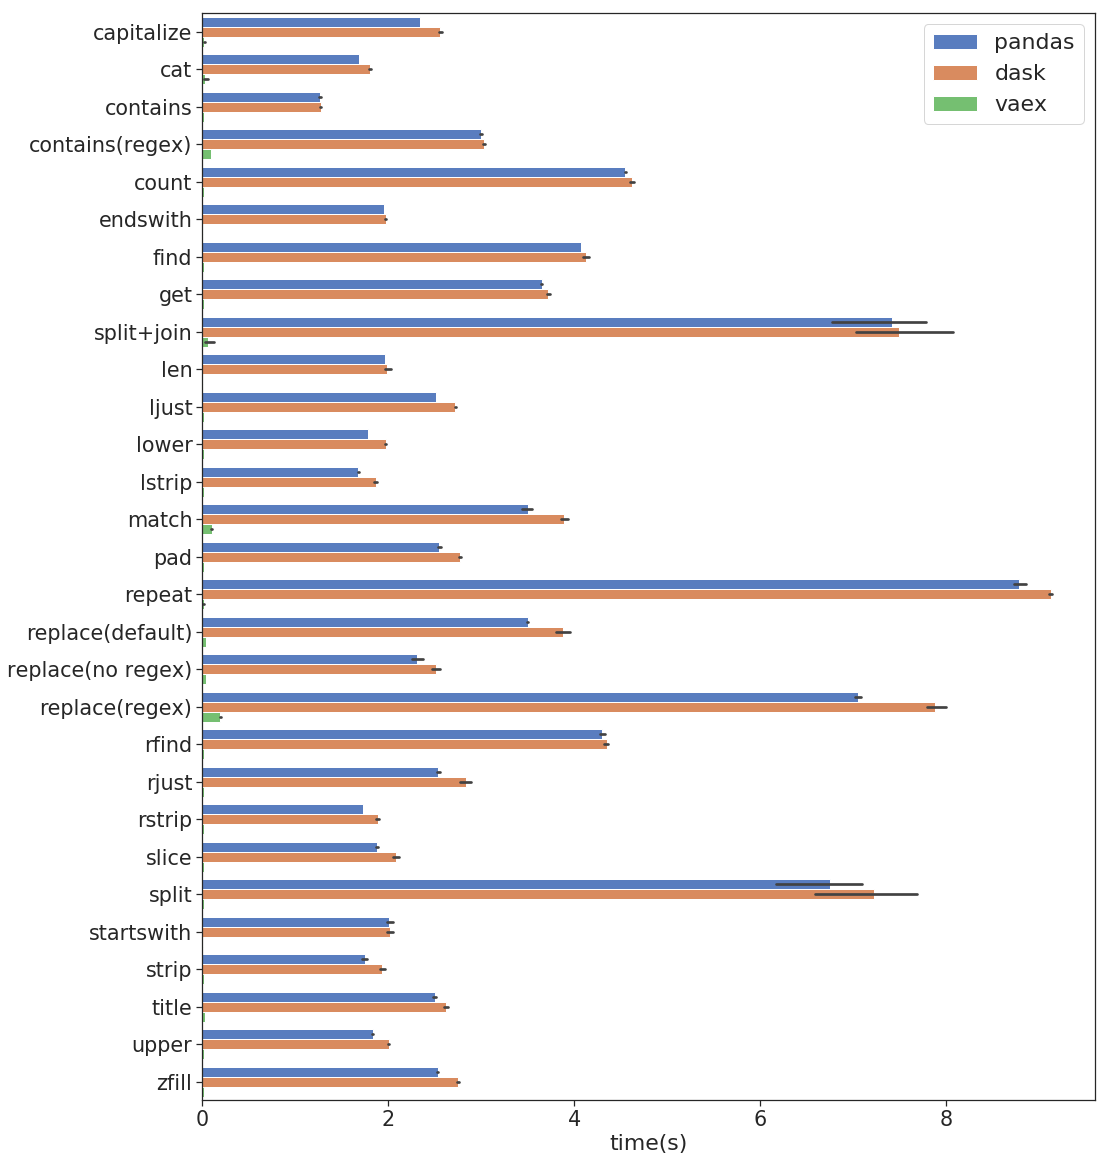

In [30]:
plt.figure(figsize=(16, 20))
ax = sns.barplot(
    data=dfp, y="method", x="time", hue="type", palette="muted"
)
ax.tick_params(axis='both', labelsize='xx-large')
ax.legend(fontsize=22)
ax.set_xlabel('time(s)', fontsize=22)
ax.set_ylabel('')

In [39]:
pd.pivot_table?

In [41]:
dfp_c = dfp.groupby(['type', 'method'])['time'].mean().reset_index().pivot_table(values='time', columns='type', index='method')

In [43]:
(dfp_c['pandas'] / dfp_c['vaex']).mean()

133.621008212719